In [1]:
import json
import random
import shutil
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

import cv2
import numpy as np
from PIL import Image

from ultralytics.utils import DATASETS_DIR, LOGGER, NUM_THREADS, TQDM
from ultralytics.utils.downloads import download
from ultralytics.utils.files import increment_path

def convert_dota_to_yolo_obb(dota_root_path: str):
    """
    Converts DOTA dataset annotations to YOLO OBB (Oriented Bounding Box) format.

    The function processes images in the 'train' and 'val' folders of the DOTA dataset. For each image, it reads the
    associated label from the original labels directory and writes new labels in YOLO OBB format to a new directory.

    Args:
        dota_root_path (str): The root directory path of the DOTA dataset.

    Example:
        ```python
        from ultralytics.data.converter import convert_dota_to_yolo_obb

        convert_dota_to_yolo_obb("path/to/DOTA")
        ```

    Notes:
        The directory structure assumed for the DOTA dataset:

            - DOTA
                ├─ images
                │   ├─ train
                │   └─ val
                └─ labels
                    ├─ train_original
                    └─ val_original

        After execution, the function will organize the labels into:

            - DOTA
                └─ labels
                    ├─ train
                    └─ val
    """
    dota_root_path = Path(dota_root_path)

    # Class names to indices mapping
    class_mapping = {
        "ground-track-field": 0,
        "basketball-court": 1,
        "volleyball-court": 2,
        "tennis-court": 3
    }

    def convert_label(image_name, image_width, image_height, orig_label_dir, save_dir):
        """Converts a single image's DOTA annotation to YOLO OBB format and saves it to a specified directory."""
        orig_label_path = orig_label_dir / f"{image_name}.txt"
        save_path = save_dir / f"{image_name}.txt"

        with orig_label_path.open("r") as f, save_path.open("w") as g:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 9:
                    continue
                class_name = parts[8]
                class_idx = class_mapping[class_name]
                coords = [float(p) for p in parts[:8]]
                normalized_coords = [
                    coords[i] / image_width if i % 2 == 0 else coords[i] / image_height for i in range(8)
                ]
                formatted_coords = [f"{coord:.6g}" for coord in normalized_coords]
                g.write(f"{class_idx} {' '.join(formatted_coords)}\n")

    for phase in ["train", "val"]:
        image_dir = dota_root_path / "images" / phase
        orig_label_dir = dota_root_path / "labels" / f"{phase}_original"
        save_dir = dota_root_path / "labels" / phase

        save_dir.mkdir(parents=True, exist_ok=True)

        image_paths = list(image_dir.iterdir())
        for image_path in TQDM(image_paths, desc=f"Processing {phase} images"):
            if image_path.suffix != ".png":
                continue
            image_name_without_ext = image_path.stem
            img = cv2.imread(str(image_path))
            h, w = img.shape[:2]
            convert_label(image_name_without_ext, w, h, orig_label_dir, save_dir)

In [2]:
convert_dota_to_yolo_obb("sports")

Processing val images: 100%|██████████| 123/123 [00:02<00:00, 48.46it/s]


In [5]:
%pip install -U ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-obb.yaml").load("pretrained/yolo11n-obb.pt")  # build from YAML and transfer weights

# Train the model with learning rate decay
results = model.train(
    data="sport_dataset.yaml",
    epochs=150,
    imgsz=1024,
    batch=16,
    device="0",
    workers=4,
    lr0=0.001,  # initial learning rate
    lrf=0.1   # final learning rate (lr0 * lrf)
)

Note: you may need to restart the kernel to use updated packages.
Transferred 499/541 items from pretrained weights
Ultralytics 8.3.56  Python-3.10.16 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=obb, mode=train, model=yolo11n-obb.yaml, data=sport.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=train2, exist_ok=False, pretrained=yolo11n.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

train: Scanning E:\YOLOv7_obb\dataset\sports\labels\train.cache... 683 images, 10 backgrounds, 0 corrupt: 100%|██████████| 683/683 [00:00<?, ?it/s]
val: Scanning E:\YOLOv7_obb\dataset\sports\labels\val.cache... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<?, ?it/s]


Plotting labels to runs\obb\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs\obb\train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      6.63G      1.947      3.683      3.052         88       1024: 100%|██████████| 43/43 [00:16<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]

                   all        123        614    0.00599      0.329      0.168      0.061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      5.88G      1.574      2.209      2.547         78       1024: 100%|██████████| 43/43 [00:13<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]

                   all        123        614      0.875      0.297      0.608      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      5.96G      1.428      1.867       2.37         56       1024: 100%|██████████| 43/43 [00:13<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

                   all        123        614      0.757      0.441      0.727      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      5.89G      1.306      1.647      2.258         38       1024: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]

                   all        123        614      0.715       0.54      0.684      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      5.97G      1.233      1.432      2.183         58       1024: 100%|██████████| 43/43 [00:13<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

                   all        123        614      0.855      0.798      0.898      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      5.96G      1.186      1.323        2.2         71       1024: 100%|██████████| 43/43 [00:13<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]

                   all        123        614      0.892      0.841      0.921      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      6.04G      1.121      1.207      2.118         69       1024: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

                   all        123        614      0.909      0.854      0.927      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      5.95G      1.053      1.119      2.115         74       1024: 100%|██████████| 43/43 [00:13<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.933      0.867      0.924        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      5.89G      1.031      1.046      1.987         40       1024: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        123        614      0.941      0.912       0.96      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      5.87G      1.042      1.005      2.051         44       1024: 100%|██████████| 43/43 [00:13<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]

                   all        123        614      0.883      0.884      0.931      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      5.91G      1.001     0.9526      1.994         67       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.937      0.884      0.956      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      5.95G     0.9664     0.9137      2.034         81       1024: 100%|██████████| 43/43 [00:13<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

                   all        123        614       0.91      0.877      0.945      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      5.87G     0.9642     0.8896      1.954         40       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

                   all        123        614      0.917       0.85       0.93      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      5.91G      0.947     0.8719      1.956         49       1024: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

                   all        123        614      0.908      0.813      0.916      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150       5.9G      0.907     0.8112      1.887         63       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

                   all        123        614      0.919      0.908      0.952      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      5.91G     0.8979      0.801      1.953         54       1024: 100%|██████████| 43/43 [00:13<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.42it/s]

                   all        123        614      0.963      0.902      0.965      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      5.95G     0.8817      0.768      1.911         77       1024: 100%|██████████| 43/43 [00:13<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

                   all        123        614      0.931      0.887      0.948      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      5.89G       0.89     0.7905      1.879         53       1024: 100%|██████████| 43/43 [00:13<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.863      0.817      0.913       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      5.83G     0.8857     0.7701      1.906         91       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.977      0.888      0.963      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      5.91G     0.8791     0.7511       1.84         60       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.959      0.883       0.96      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      5.92G     0.8564     0.7137      1.882         87       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]

                   all        123        614      0.953       0.93       0.97      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150       5.9G     0.8575     0.7171      1.835         98       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.956      0.913      0.967      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      5.97G     0.8258     0.6804      1.844         98       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.968      0.903      0.966      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150       5.9G     0.8375     0.7023      1.812         60       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]

                   all        123        614      0.948      0.903      0.962      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      5.91G     0.8144     0.6749      1.818         63       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614      0.969      0.892      0.972      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      5.83G     0.7949     0.6644      1.754         55       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

                   all        123        614      0.959       0.91      0.971      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      5.94G     0.8092     0.6744       1.81         75       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

                   all        123        614      0.945      0.886      0.955      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      5.86G     0.8001     0.6503        1.8         55       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]

                   all        123        614      0.962      0.903      0.959      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      5.95G     0.7814     0.6504      1.798         72       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.961       0.89      0.962      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      5.87G     0.8276     0.6688      1.819         44       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

                   all        123        614      0.944      0.917       0.95      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      5.89G     0.8029       0.67      1.786         94       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.936      0.902      0.953      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      5.87G      0.782      0.643      1.748         28       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614       0.96      0.898      0.955      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      5.88G     0.7791     0.6377      1.798         56       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.63it/s]

                   all        123        614       0.96       0.87      0.946      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      5.93G     0.7654     0.6105      1.746         84       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.932      0.867      0.928      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      5.96G     0.7506      0.609      1.762         36       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]

                   all        123        614       0.97      0.879      0.955      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      5.88G     0.7652     0.6119      1.747         69       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

                   all        123        614      0.946      0.927      0.969       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      5.93G     0.7577     0.6077      1.727         59       1024: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

                   all        123        614      0.968      0.893      0.963      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      5.88G     0.7497     0.5998      1.734        109       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]

                   all        123        614      0.954      0.925      0.975      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      5.95G     0.7406     0.5856      1.736         63       1024: 100%|██████████| 43/43 [00:13<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.967      0.904      0.974      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      5.96G     0.7381     0.5882      1.754         65       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

                   all        123        614      0.966      0.935      0.969      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      5.95G     0.7219     0.5712      1.746         61       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        123        614      0.968      0.911      0.969      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      5.86G     0.7175     0.5686      1.709        110       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.962      0.903      0.962      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      5.88G      0.735     0.5703      1.752         61       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614      0.984      0.907      0.972      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150       5.9G     0.7115     0.5669       1.67         76       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.946       0.92      0.966      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      5.89G     0.7092       0.56      1.684         57       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        123        614      0.953      0.914      0.972       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      6.04G     0.6984     0.5589      1.709         71       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614       0.97      0.911      0.958       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      5.97G     0.7103     0.5823      1.711         78       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614       0.93      0.916      0.958      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      5.95G     0.7006     0.5532      1.739         63       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

                   all        123        614       0.97      0.915      0.971      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150       5.9G     0.7063     0.5637      1.693         75       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

                   all        123        614      0.961      0.925      0.977      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      5.91G     0.6907     0.5412      1.683         88       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

                   all        123        614      0.946      0.922      0.967      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      5.95G     0.6716     0.5265      1.654         90       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.968      0.914      0.972      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150       5.9G      0.684     0.5462      1.645         73       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

                   all        123        614      0.972      0.907      0.959       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      5.94G      0.671     0.5376       1.71         77       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.88it/s]

                   all        123        614      0.974        0.9       0.94      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      5.91G     0.6735     0.5309      1.655         84       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]

                   all        123        614      0.959      0.901      0.954      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      5.91G     0.6815     0.5172      1.684         60       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

                   all        123        614      0.963      0.927      0.975      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      5.83G     0.6851     0.5243      1.667         88       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.975      0.915      0.972      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      5.97G     0.6864     0.5287       1.64         49       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

                   all        123        614      0.962      0.913      0.966      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      5.97G     0.6534     0.5115      1.601         46       1024: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.971      0.936       0.98      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      5.85G     0.6644     0.5184      1.627         71       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.965      0.931      0.966      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      5.96G     0.6538     0.5117      1.653        110       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

                   all        123        614      0.958      0.927      0.966      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      5.88G     0.6555     0.4999      1.636         81       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614      0.962      0.934      0.974      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150       5.9G     0.6444     0.4963      1.624         74       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

                   all        123        614      0.976      0.933      0.975      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      5.91G      0.663     0.5012      1.609         60       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

                   all        123        614      0.978      0.928       0.98       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       5.9G     0.6549     0.5101      1.673         82       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

                   all        123        614      0.965      0.924      0.969      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      5.91G     0.6679     0.5219      1.633         56       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

                   all        123        614      0.966      0.937      0.971      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150       5.9G     0.6508     0.4947      1.582         67       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.982      0.931      0.964      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      5.96G      0.634     0.5023      1.598         82       1024: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.975      0.919      0.963      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      5.89G     0.6346     0.4974       1.64         65       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.963      0.917      0.957       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      5.94G     0.6629     0.5111      1.634         65       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.971      0.932      0.966      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      5.91G     0.6298     0.4895      1.565         59       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]

                   all        123        614      0.951      0.941      0.974      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      5.89G     0.6262     0.4915      1.566         44       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614      0.979      0.926      0.973      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      5.99G     0.6146      0.478      1.576         95       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

                   all        123        614      0.976      0.931      0.982      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      5.88G     0.6381     0.4945      1.589         74       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.953      0.942      0.973      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      5.91G     0.6353     0.4845      1.586         64       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

                   all        123        614      0.967      0.923       0.97       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      5.88G     0.6126     0.4691       1.58         69       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        123        614      0.981      0.939       0.98      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      5.97G     0.6244     0.4681      1.607         79       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        123        614      0.956      0.936      0.971      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      5.98G     0.6227     0.4744      1.579         52       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

                   all        123        614      0.959      0.936      0.969      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      5.91G     0.6189     0.4708      1.597         37       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.978      0.923      0.963       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      5.95G     0.6039     0.4666      1.598         58       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.957      0.931      0.966      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      5.89G     0.6041     0.4553      1.599         61       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614      0.975      0.912      0.964      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      5.95G     0.6121     0.4546      1.574         61       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

                   all        123        614      0.962      0.935      0.972      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      5.91G     0.5995     0.4708      1.538         73       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]

                   all        123        614      0.964      0.928      0.968      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      5.93G     0.6117      0.468      1.538         63       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

                   all        123        614      0.943      0.927      0.956      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      5.98G     0.5857     0.4424      1.549         73       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        123        614      0.959       0.93      0.967      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      5.96G     0.6055     0.4585      1.575        108       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.955       0.94      0.969      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      5.95G     0.6034     0.4703      1.606         42       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]

                   all        123        614      0.945      0.934      0.963      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      5.94G     0.5962     0.4537      1.519        112       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.968      0.933      0.965       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      5.82G     0.5827     0.4467       1.53         36       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.85it/s]

                   all        123        614      0.978      0.923      0.967      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       5.9G     0.5807     0.4491       1.56        103       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614      0.969      0.928      0.965      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      5.91G     0.5808     0.4414      1.522         69       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

                   all        123        614      0.978      0.926      0.977      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      5.89G     0.5848     0.4528      1.521         69       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.958      0.929      0.971       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      5.95G     0.5741       0.44      1.503         72       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]

                   all        123        614      0.978      0.941      0.981      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      6.02G     0.5842     0.4495      1.561         76       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]

                   all        123        614      0.977      0.943      0.974      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      5.97G     0.5567     0.4201       1.49         78       1024: 100%|██████████| 43/43 [00:13<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

                   all        123        614      0.945      0.947      0.969      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      5.85G     0.5704     0.4406      1.532         79       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.947      0.947      0.972      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      5.89G     0.5668     0.4424      1.506         55       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]

                   all        123        614      0.976      0.925       0.97      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      5.89G     0.5742     0.4384      1.538         70       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.53it/s]

                   all        123        614      0.961      0.942       0.97      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      5.89G     0.5589     0.4269      1.503         82       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]

                   all        123        614      0.972      0.956      0.979       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      5.91G     0.5684     0.4326      1.502         62       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]

                   all        123        614      0.988      0.926      0.975      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150       5.9G     0.5494     0.4232      1.503         48       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        123        614      0.953      0.953      0.975      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      6.02G     0.5671     0.4321       1.52         54       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

                   all        123        614      0.969      0.932      0.974      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      5.96G     0.5575     0.4203      1.515         64       1024: 100%|██████████| 43/43 [00:14<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

                   all        123        614      0.963      0.929       0.97      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      5.87G     0.5722     0.4379      1.512         96       1024: 100%|██████████| 43/43 [00:13<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

                   all        123        614      0.971      0.931      0.981      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      5.93G     0.5564     0.4281      1.478         70       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

                   all        123        614      0.955      0.938      0.975      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      5.88G      0.553      0.417      1.463         67       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        123        614       0.98      0.926      0.976      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       5.9G     0.5472     0.4243      1.484         60       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.73it/s]

                   all        123        614      0.967      0.949      0.979      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      5.85G     0.5377     0.4162      1.487         83       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.967      0.949      0.977      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      5.95G     0.5551     0.4191      1.514         56       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        123        614      0.982      0.934      0.972      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      5.91G     0.5449     0.4132      1.512         58       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

                   all        123        614      0.957      0.936      0.972      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      5.87G     0.5555     0.4235      1.488         60       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]

                   all        123        614       0.98      0.927       0.97       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      5.89G     0.5241     0.4084      1.458         61       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

                   all        123        614      0.968      0.946       0.98      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      5.83G     0.5332     0.4059      1.452        111       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

                   all        123        614      0.974      0.948      0.976      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      6.18G     0.5268     0.3997      1.434         66       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

                   all        123        614      0.961      0.936      0.973      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      5.93G     0.5328     0.4037      1.454         50       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614       0.98      0.935       0.98      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      5.93G      0.552     0.4186      1.526         88       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]

                   all        123        614      0.967      0.944      0.973      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      5.89G     0.5184      0.397      1.438         97       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

                   all        123        614      0.948      0.948      0.972      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      5.89G     0.5352     0.4058      1.467         56       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614       0.97      0.942      0.973      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      5.96G     0.5345     0.4063      1.485         50       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]

                   all        123        614      0.964      0.932       0.97      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      5.89G     0.5396     0.4155      1.482         31       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]

                   all        123        614      0.959      0.944      0.973       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150       5.9G     0.5262     0.3948      1.448         52       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.972      0.937      0.969      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      5.85G     0.5305     0.3995      1.467         84       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

                   all        123        614      0.972      0.927      0.967      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      5.94G       0.53     0.4088      1.445         62       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]

                   all        123        614      0.952      0.938      0.967      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      5.96G     0.5175      0.402      1.432         86       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]

                   all        123        614      0.967       0.93      0.967      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      5.91G     0.5139     0.3964      1.423         74       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

                   all        123        614      0.971       0.92       0.96      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      5.89G     0.5339     0.4093      1.443         66       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.958      0.927      0.971      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       5.9G     0.5189      0.408      1.444         72       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]

                   all        123        614      0.986        0.9      0.965       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      5.94G     0.5064     0.3883      1.416         66       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        123        614      0.981      0.926      0.975      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      5.94G     0.5054     0.3926      1.443         77       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

                   all        123        614      0.965      0.948      0.982      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      5.89G     0.5016     0.3873      1.407         81       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

                   all        123        614      0.976      0.935      0.975      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      5.95G     0.5095     0.3909      1.419         79       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.975      0.931      0.965      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      5.96G      0.507     0.3874      1.419         53       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

                   all        123        614      0.973      0.927      0.962      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      5.95G     0.5018     0.3936      1.431         95       1024: 100%|██████████| 43/43 [00:13<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.74it/s]

                   all        123        614      0.962      0.937      0.965      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      5.93G     0.5061     0.3964      1.422         50       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.68it/s]

                   all        123        614      0.966      0.928       0.96      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      5.85G     0.5118     0.3958      1.427         65       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

                   all        123        614      0.968      0.926      0.963      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      5.95G     0.4911     0.3815       1.39         71       1024: 100%|██████████| 43/43 [00:13<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]

                   all        123        614      0.983      0.918      0.965      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      5.85G     0.5115     0.3983      1.446         47       1024: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.975      0.929      0.975      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      5.85G     0.4962     0.3833      1.416         56       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

                   all        123        614      0.956      0.951      0.981      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      5.89G     0.5106     0.3986      1.434         79       1024: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.976      0.921      0.973      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      5.98G     0.4918     0.3783      1.408         54       1024: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.83it/s]

                   all        123        614      0.955      0.941      0.971      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      5.91G     0.4731     0.3678      1.395         68       1024: 100%|██████████| 43/43 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.77it/s]

                   all        123        614      0.952      0.942      0.968      0.895


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      6.47G     0.4331     0.3408      1.421         50       1024: 100%|██████████| 43/43 [00:14<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.90it/s]

                   all        123        614      0.981      0.909      0.961      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150       5.9G      0.426     0.3359      1.406         36       1024: 100%|██████████| 43/43 [00:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.98it/s]

                   all        123        614      0.985      0.909      0.966      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150       5.8G      0.402     0.3081       1.34         52       1024: 100%|██████████| 43/43 [00:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]

                   all        123        614      0.979      0.914      0.968      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      5.83G     0.3996       0.31      1.349         33       1024: 100%|██████████| 43/43 [00:13<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.971      0.927      0.964      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      5.88G     0.4118     0.3181      1.375         35       1024: 100%|██████████| 43/43 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.79it/s]

                   all        123        614      0.973      0.931      0.968      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      5.85G     0.4006     0.3076       1.35         51       1024: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

                   all        123        614      0.962      0.938      0.966      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      5.82G     0.4025      0.314      1.372         65       1024: 100%|██████████| 43/43 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.80it/s]

                   all        123        614      0.963      0.927      0.963      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      5.85G     0.4056     0.3135      1.348         46       1024: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.86it/s]

                   all        123        614      0.963      0.921      0.965      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      5.82G      0.404     0.3139      1.372         62       1024: 100%|██████████| 43/43 [00:13<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.75it/s]

                   all        123        614      0.944      0.942      0.965      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      5.89G     0.3982     0.3056      1.362         26       1024: 100%|██████████| 43/43 [00:13<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

                   all        123        614      0.972      0.926      0.967      0.894



150 epochs completed in 0.675 hours.
Optimizer stripped from runs\obb\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\obb\train2\weights\best.pt, 6.2MB

Validating runs\obb\train2\weights\best.pt...
Ultralytics 8.3.56  Python-3.10.16 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11n-obb summary (fused): 257 layers, 2,654,503 parameters, 0 gradients, 6.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


                   all        123        614      0.965      0.948      0.982        0.9
    ground-track-field         98        103      0.971      0.971      0.986      0.867
      basketball-court        102        350      0.968      0.964      0.984      0.938
      volleyball-court         42         78      0.971      0.857      0.972       0.88
          tennis-court         33         83       0.95          1      0.985      0.915
Speed: 0.9ms preprocess, 5.0ms inference, 0.0ms loss, 6.6ms postprocess per image
Results saved to runs\obb\train2


In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11s-obb.yaml").load("pretrained/yolo11s-obb.pt")  # build from YAML and transfer weights

# Train the model with learning rate decay
results = model.train(
    data="sport_dataset.yaml",
    epochs=150,
    imgsz=1024,
    batch=8,
    device="0",
    workers=4,
    lr0=0.001,  # initial learning rate
    lrf=0.1   # final learning rate (lr0 * lrf)
)

Transferred 535/541 items from pretrained weights
Ultralytics 8.3.56  Python-3.10.16 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=obb, mode=train, model=yolo11s-obb.yaml, data=sport.yaml, epochs=200, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=train6, exist_ok=False, pretrained=yolo11s-obb.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

train: Scanning E:\YOLOv7_obb\dataset\sports\labels\train.cache... 683 images, 10 backgrounds, 0 corrupt: 100%|██████████| 683/683 [00:00<?, ?it/s]
val: Scanning E:\YOLOv7_obb\dataset\sports\labels\val.cache... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<?, ?it/s]


Plotting labels to runs\obb\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs\obb\train6
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      5.46G     0.9246      2.525      1.869         10       1024: 100%|██████████| 86/86 [00:30<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/16 [00:00<?, ?it/s]

WARNING  NMS time limit 2.400s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]

                   all        123        614      0.606      0.873      0.785      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      5.65G     0.8241      1.163      1.678         11       1024: 100%|██████████| 86/86 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.50it/s]

                   all        123        614      0.876      0.862      0.923      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      5.62G     0.8161     0.8821      1.644         16       1024: 100%|██████████| 86/86 [00:25<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  7.05it/s]

                   all        123        614      0.921      0.831       0.91      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      5.65G     0.8301     0.8765      1.659         19       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.73it/s]

                   all        123        614      0.942      0.903      0.956      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200       5.6G     0.8203     0.7671      1.671         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.99it/s]

                   all        123        614      0.949      0.842      0.957        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      5.63G     0.7812     0.7081      1.644         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]

                   all        123        614      0.952      0.935      0.978      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      5.65G     0.7484     0.6663      1.604         28       1024: 100%|██████████| 86/86 [00:24<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]

                   all        123        614      0.962      0.916      0.963      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      5.58G     0.7419     0.6485      1.639         31       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]

                   all        123        614      0.955      0.881      0.956      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      5.55G      0.729       0.66      1.583         27       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]

                   all        123        614       0.95      0.909      0.963      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       5.6G     0.7097     0.6235      1.564         18       1024: 100%|██████████| 86/86 [00:25<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.12it/s]

                   all        123        614      0.958      0.932      0.971      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      5.58G     0.7371     0.6202      1.556         18       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]

                   all        123        614      0.969      0.918      0.969      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      5.69G     0.7131     0.6054      1.592         34       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]

                   all        123        614      0.956      0.927      0.974      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200       5.6G     0.6967     0.5854      1.544         14       1024: 100%|██████████| 86/86 [00:25<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.32it/s]

                   all        123        614      0.967      0.917      0.973      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      5.59G     0.6987     0.5805       1.56         15       1024: 100%|██████████| 86/86 [00:25<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.88it/s]

                   all        123        614      0.965      0.925      0.979      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      5.63G     0.7027      0.568      1.544         19       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]

                   all        123        614      0.937       0.93      0.973      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      5.59G     0.6852     0.5728      1.554          8       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]

                   all        123        614      0.962      0.913      0.969      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      5.67G     0.6855     0.5708      1.589         16       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]

                   all        123        614      0.991      0.902       0.97      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      5.58G     0.6537     0.5338      1.572          9       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]

                   all        123        614      0.978      0.935      0.978      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      5.59G     0.6749     0.5548      1.555         18       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]

                   all        123        614      0.954      0.923      0.972       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       5.6G     0.6822     0.5541      1.545         25       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]

                   all        123        614      0.965      0.927      0.975      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      5.61G     0.6255     0.5148      1.474         32       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]

                   all        123        614      0.966      0.926      0.976      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      5.64G     0.6391     0.5351      1.548         17       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]

                   all        123        614      0.962      0.929      0.961      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      5.58G     0.6788     0.5903      1.542          1       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]

                   all        123        614      0.959      0.931      0.972      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      5.58G     0.6299     0.5221       1.46         16       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]

                   all        123        614      0.973      0.905       0.97      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200       5.6G     0.6234     0.5138       1.52          7       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]

                   all        123        614      0.967      0.954       0.98      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       5.6G     0.6473     0.5281       1.52         18       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]

                   all        123        614      0.959      0.929      0.974      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      5.61G     0.6112     0.5108      1.481          9       1024: 100%|██████████| 86/86 [00:25<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.25it/s]

                   all        123        614      0.958      0.924      0.973      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      5.58G     0.6055     0.4911      1.466         22       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.19it/s]

                   all        123        614      0.969      0.926      0.978      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      5.57G      0.623       0.51      1.512         14       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]

                   all        123        614      0.963      0.926      0.973      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      5.58G     0.6273     0.4984      1.478          5       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]

                   all        123        614      0.964      0.953      0.978      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      5.62G     0.6175     0.4897       1.48         20       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]

                   all        123        614      0.959      0.932      0.972      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      5.62G     0.6114     0.4923        1.5         18       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.47it/s]

                   all        123        614      0.952       0.95      0.975       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      5.61G     0.5987     0.4751      1.451         17       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]

                   all        123        614       0.97      0.943      0.976       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      5.62G     0.5903     0.4849      1.445         13       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.11it/s]

                   all        123        614      0.965      0.931      0.972      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      5.68G     0.5777     0.4655      1.412         18       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]

                   all        123        614      0.969      0.927       0.98      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      5.58G     0.6025     0.4852      1.459         22       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]

                   all        123        614      0.946      0.965      0.982      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      5.59G     0.5836     0.4614      1.466         15       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]

                   all        123        614      0.977      0.939      0.983      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      5.58G     0.5832     0.4581      1.445         27       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]

                   all        123        614      0.945      0.934      0.963      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      5.61G     0.5779     0.4647       1.48         14       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]

                   all        123        614      0.947      0.932      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      5.65G     0.5646     0.4484       1.45         18       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.44it/s]

                   all        123        614      0.959      0.948       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200       5.6G     0.5642     0.4509      1.424         27       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.57it/s]

                   all        123        614       0.97      0.955      0.979      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      5.62G     0.5624     0.4399      1.424         17       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.956      0.933      0.973      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      5.62G     0.5678     0.4409      1.429         23       1024: 100%|██████████| 86/86 [00:24<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]

                   all        123        614      0.969      0.959      0.983      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      5.58G     0.5664     0.4488      1.414         13       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]

                   all        123        614      0.945      0.954      0.978      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      5.63G     0.5734     0.4532      1.458         15       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]

                   all        123        614      0.966      0.948      0.984        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      5.67G     0.5556     0.4441      1.419         23       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.25it/s]

                   all        123        614      0.962      0.929       0.97      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      5.58G     0.5673     0.4569      1.417         17       1024: 100%|██████████| 86/86 [00:25<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.37it/s]

                   all        123        614      0.978      0.928      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      5.63G     0.5655     0.4526      1.451         19       1024: 100%|██████████| 86/86 [00:25<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]

                   all        123        614      0.971      0.933       0.98      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      5.57G     0.5738     0.4482      1.447          5       1024: 100%|██████████| 86/86 [00:25<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]

                   all        123        614      0.969      0.916      0.969      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      5.61G     0.5497     0.4499      1.416         10       1024: 100%|██████████| 86/86 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]

                   all        123        614      0.967       0.95      0.981      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      5.58G     0.5557     0.4401      1.422         13       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]

                   all        123        614      0.975      0.938      0.978      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      5.58G     0.5379       0.43      1.423         27       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]

                   all        123        614      0.959      0.931      0.975      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      5.59G     0.5587     0.4404      1.461         14       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.53it/s]

                   all        123        614      0.957      0.947      0.978        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      5.68G     0.5204     0.4135      1.367          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.954      0.952      0.979      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      5.61G     0.5386     0.4274      1.396         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]

                   all        123        614      0.947      0.957      0.981      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       5.6G     0.5364     0.4363      1.406          9       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]

                   all        123        614      0.944      0.954      0.976      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200       5.6G     0.5235     0.4073      1.391         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]

                   all        123        614      0.969      0.948      0.973      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      5.59G     0.5356     0.4236      1.371         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]

                   all        123        614      0.973      0.928      0.967      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      5.68G     0.5264     0.4194       1.38         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]

                   all        123        614      0.983      0.934      0.978      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       5.6G     0.5237     0.4098      1.411          7       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]

                   all        123        614      0.974      0.936      0.976      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      5.59G     0.5284     0.4033       1.37         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614      0.963      0.934      0.976      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      5.61G     0.5221     0.4107      1.377         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]

                   all        123        614      0.985      0.921      0.979      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      5.61G     0.5176     0.4124      1.423         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.978      0.923       0.97      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      5.58G     0.5587     0.4442      1.391         22       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]

                   all        123        614      0.965      0.952      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      5.57G     0.5429     0.4248      1.432          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]

                   all        123        614      0.964      0.941      0.979      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       5.6G     0.5154     0.3987      1.369          6       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]

                   all        123        614      0.975      0.946      0.978      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      5.57G     0.5109     0.4001      1.333         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]

                   all        123        614      0.966      0.952      0.984       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      5.58G     0.5371     0.4237      1.428         28       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.88it/s]

                   all        123        614      0.952      0.948      0.976      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200       5.6G     0.5331     0.4195      1.355         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]

                   all        123        614      0.967      0.931      0.975      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      5.58G     0.5064      0.392      1.365         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]

                   all        123        614      0.965      0.936      0.979      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      5.58G     0.5189     0.3964      1.351         16       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]

                   all        123        614      0.965       0.95      0.978      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      5.62G     0.5277     0.4135      1.389          6       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.969      0.941      0.966      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      5.59G     0.5238     0.4134      1.373         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]

                   all        123        614      0.977      0.946      0.976      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      5.68G     0.5217     0.4107      1.371         33       1024: 100%|██████████| 86/86 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]

                   all        123        614       0.96      0.947       0.97      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      5.58G     0.5038      0.404      1.368         33       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]

                   all        123        614      0.971      0.951      0.979      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      5.58G     0.5109     0.3976      1.379         23       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.20it/s]

                   all        123        614      0.967       0.94      0.974      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      5.56G      0.513      0.401      1.347         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]

                   all        123        614      0.948      0.965       0.98      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      5.59G     0.5297     0.4103      1.371         30       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.43it/s]

                   all        123        614      0.958      0.937      0.967      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      5.59G     0.5137     0.4077      1.367          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.27it/s]

                   all        123        614      0.964       0.96      0.981      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      5.61G     0.4842     0.3741      1.329         38       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.972      0.935      0.973      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      5.56G      0.493     0.3803      1.336         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614       0.96      0.939      0.966      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      5.57G     0.4993     0.3888      1.356         28       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.952      0.944      0.966       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      5.58G     0.4868     0.3866      1.334         52       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.40it/s]

                   all        123        614      0.968       0.94       0.97      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       5.6G     0.4791     0.3733      1.313         24       1024: 100%|██████████| 86/86 [00:24<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]

                   all        123        614      0.965      0.951      0.978      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      5.61G     0.5046     0.3897      1.363         14       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.24it/s]

                   all        123        614      0.957      0.949      0.977      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      5.58G     0.4773      0.376       1.35         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]

                   all        123        614      0.979      0.926      0.971      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      5.58G      0.484     0.3814      1.351         39       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.07it/s]

                   all        123        614      0.969      0.929      0.969      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      5.61G     0.4799     0.3696      1.299         14       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]

                   all        123        614       0.97      0.947      0.982      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      5.57G     0.4991      0.389       1.35          5       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]

                   all        123        614      0.974      0.937      0.975      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      5.62G     0.4826     0.3763      1.324         34       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]

                   all        123        614      0.977      0.925      0.979      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      5.64G     0.4869      0.381      1.335         16       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]

                   all        123        614       0.96      0.941      0.981      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      5.63G     0.4885     0.3771      1.342         16       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614      0.982      0.946      0.982      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       5.6G     0.4876     0.3889      1.325          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614       0.96      0.949      0.972      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      5.61G     0.5003     0.3944      1.331         27       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.954      0.956      0.983       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      5.63G     0.4805     0.3765      1.312         18       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.962       0.94      0.965      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      5.57G     0.4765     0.3749      1.341         58       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.971      0.927      0.969      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      5.59G     0.4798     0.3766      1.331         23       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]

                   all        123        614      0.971      0.938      0.971      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      5.64G     0.4751     0.3716      1.315         16       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.963      0.959      0.981      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      5.58G     0.4784     0.3677      1.324         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614      0.979       0.94      0.974      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      5.64G     0.4695     0.3611      1.311         17       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]

                   all        123        614      0.971       0.94      0.971      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      5.58G     0.4552     0.3505      1.259         33       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.974      0.931      0.967      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      5.58G     0.4836      0.375      1.342         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.969      0.951      0.978      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      5.59G     0.4712      0.372      1.309         31       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.958      0.945      0.975      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      5.58G     0.4679     0.3606      1.285         19       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614      0.979      0.939      0.968      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      5.59G     0.4783     0.3698      1.329         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.35it/s]

                   all        123        614      0.979       0.95      0.974      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      5.61G      0.458     0.3615       1.31         22       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]

                   all        123        614      0.982      0.938      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      5.59G     0.4777     0.3758       1.32         24       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.965      0.955      0.978      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      5.64G     0.4666     0.3667      1.299         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]

                   all        123        614      0.969      0.946      0.975      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      5.62G     0.4675     0.3677      1.323         27       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.979       0.93      0.976      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      5.64G     0.4678     0.3677      1.313         14       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]

                   all        123        614      0.984      0.916      0.974      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      5.64G     0.4615     0.3615      1.307         29       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]

                   all        123        614      0.969      0.936      0.977      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      5.61G     0.4593     0.3685      1.314          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]

                   all        123        614      0.967       0.95      0.974      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      5.61G     0.4393      0.344       1.27         38       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]

                   all        123        614      0.974      0.952       0.98      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      5.58G     0.4538     0.3629      1.282         16       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]

                   all        123        614      0.962      0.961      0.985      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      5.59G      0.446     0.3506      1.283         24       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614      0.973      0.955      0.985      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200       5.6G     0.4626     0.3695      1.309          6       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]

                   all        123        614      0.967      0.942      0.965        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      5.56G     0.4471     0.3529      1.304         29       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614      0.973      0.946      0.979      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      5.62G     0.4425     0.3498      1.276         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]

                   all        123        614      0.968      0.947      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200       5.6G     0.4385     0.3438      1.273         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614      0.979      0.945      0.987      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      5.59G      0.437     0.3419      1.282         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.60it/s]

                   all        123        614      0.969       0.96       0.98      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      5.56G     0.4389     0.3366      1.258         39       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.976      0.949      0.976      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      5.59G     0.4307     0.3297       1.26         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.41it/s]

                   all        123        614      0.975      0.949      0.974      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      5.58G     0.4571     0.3579       1.28         26       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.972      0.953      0.977      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      5.62G     0.4424     0.3455      1.296         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]

                   all        123        614      0.975      0.947      0.971      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      5.58G     0.4346     0.3334      1.244         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.977      0.947      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      5.59G     0.4378     0.3371      1.276         26       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]

                   all        123        614      0.975      0.962      0.978      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      5.58G     0.4492     0.3402      1.288         25       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]

                   all        123        614       0.98      0.952      0.984       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      5.62G      0.442     0.3491      1.279         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]

                   all        123        614      0.974      0.952      0.983      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200       5.6G     0.4301     0.3385      1.288          6       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]

                   all        123        614      0.976      0.948      0.976      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      5.59G     0.4319      0.339      1.273         24       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.81it/s]

                   all        123        614      0.958       0.97      0.985      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      5.64G     0.4286     0.3384      1.267         17       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.975      0.958      0.977      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      5.61G     0.4254     0.3337      1.259         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]

                   all        123        614      0.966      0.957      0.972      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.61G     0.4253     0.3321      1.271         19       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.966      0.948      0.973      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      5.64G     0.4243     0.3284      1.236         24       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614       0.97       0.96      0.978      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      5.58G      0.426     0.3286      1.267         23       1024: 100%|██████████| 86/86 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]

                   all        123        614      0.977      0.956      0.977       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      5.59G     0.4266     0.3283      1.255         30       1024: 100%|██████████| 86/86 [00:25<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]

                   all        123        614      0.978      0.962      0.981       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      5.66G     0.4247     0.3414       1.25         32       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]

                   all        123        614      0.971      0.966      0.985      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      5.61G     0.4239     0.3344      1.259         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.84it/s]

                   all        123        614      0.978      0.955      0.979      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      5.59G     0.4272     0.3378      1.267         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.83it/s]

                   all        123        614      0.972      0.942      0.969      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      5.64G     0.4261     0.3285      1.262          9       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.34it/s]

                   all        123        614       0.97      0.942      0.978      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      5.57G     0.4347     0.3438      1.275         22       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.971      0.951      0.976       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      5.61G     0.4303     0.3383      1.265         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.971      0.953       0.98      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      5.63G     0.4252     0.3327      1.244         26       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614       0.97      0.946      0.972      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.61G     0.4223     0.3349      1.242         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.972      0.956      0.979      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      5.57G      0.412     0.3174      1.217         16       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.74it/s]

                   all        123        614       0.97      0.952      0.977      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       5.6G      0.416      0.336      1.257         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]

                   all        123        614      0.972      0.943      0.974      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      5.58G     0.4241     0.3446      1.282         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]

                   all        123        614       0.97      0.949      0.977      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       5.6G     0.4197     0.3226      1.251         22       1024: 100%|██████████| 86/86 [00:24<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]

                   all        123        614      0.961      0.942      0.977      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      5.58G     0.4209     0.3332      1.249         26       1024: 100%|██████████| 86/86 [00:24<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.78it/s]

                   all        123        614       0.96      0.955      0.978      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       5.6G     0.4182     0.3276      1.249         19       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.56it/s]

                   all        123        614      0.948      0.957      0.978      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      5.61G     0.4196     0.3299      1.248         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]

                   all        123        614      0.955      0.957      0.977      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      5.62G     0.4025     0.3131      1.238         11       1024: 100%|██████████| 86/86 [00:25<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.975      0.952      0.978      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      5.65G     0.3991      0.324      1.235          3       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614      0.977      0.934      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      5.58G     0.4053     0.3166       1.23         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.973      0.941      0.972      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      5.62G     0.3992     0.3186      1.217          9       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.68it/s]

                   all        123        614      0.978      0.951      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200       5.6G     0.4158     0.3254      1.248          9       1024: 100%|██████████| 86/86 [00:25<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.48it/s]

                   all        123        614      0.958      0.957      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      5.62G     0.4013     0.3127      1.239         27       1024: 100%|██████████| 86/86 [00:25<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.49it/s]

                   all        123        614      0.961      0.952      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200       5.6G     0.4103     0.3194      1.232         17       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614      0.966      0.962      0.978      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      5.61G     0.4116     0.3213      1.241          7       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]

                   all        123        614      0.964      0.951      0.975      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      5.67G     0.3972     0.3086      1.223         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]

                   all        123        614      0.965      0.962      0.979      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.65G     0.4001      0.317      1.224         17       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614      0.973      0.949      0.979      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      5.61G     0.4002     0.3145      1.222         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.965      0.959       0.98      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.61G     0.3913     0.3123      1.217         26       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.972      0.946      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      5.62G     0.3942     0.3154      1.218         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.973       0.95      0.978      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      5.61G     0.3946     0.3118      1.234         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]

                   all        123        614       0.96      0.951      0.976      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      5.64G     0.3884     0.3084      1.212         24       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.33it/s]

                   all        123        614       0.96      0.952      0.978      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      5.58G     0.3927     0.3187      1.209         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.968      0.939      0.972      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.58G     0.3847     0.3038      1.227         12       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.967      0.938      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      5.57G     0.3802     0.3036      1.219         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.59it/s]

                   all        123        614      0.966      0.941      0.981      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      5.58G     0.3757     0.3013      1.194         25       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.958      0.947      0.978      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       5.6G     0.3837     0.3054      1.214         26       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]

                   all        123        614      0.954      0.947      0.973      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200       5.6G     0.3752     0.2977      1.214         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]

                   all        123        614      0.977      0.932      0.978      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200       5.6G     0.3907     0.3119      1.217          6       1024: 100%|██████████| 86/86 [00:25<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.45it/s]

                   all        123        614      0.962      0.954       0.98      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      5.58G     0.3762     0.3034       1.22         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.958      0.948      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200       5.6G     0.3777     0.3102      1.196         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.55it/s]

                   all        123        614      0.966      0.944      0.975      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      5.61G     0.3824     0.3066      1.213          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]

                   all        123        614      0.965      0.951      0.977      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200       5.6G     0.3661     0.2911      1.188         18       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]

                   all        123        614      0.967      0.951      0.979      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      5.57G     0.3856     0.3057      1.216         14       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]

                   all        123        614      0.953      0.961      0.979      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.64G     0.3694      0.301      1.192          9       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.69it/s]

                   all        123        614      0.981      0.927      0.978      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      5.61G     0.3846     0.3123      1.223         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]

                   all        123        614      0.952      0.957      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      5.55G     0.3779     0.2939      1.217         13       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.958      0.943      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      5.61G      0.383     0.3017      1.207         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.61it/s]

                   all        123        614      0.952      0.954      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      5.61G       0.38     0.3004      1.213         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.62it/s]

                   all        123        614      0.959      0.954      0.978      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      5.58G      0.372      0.299      1.206         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]

                   all        123        614      0.963      0.955      0.976      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      5.59G     0.3773      0.297      1.215         21       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.72it/s]

                   all        123        614      0.966      0.947      0.975       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      5.58G     0.3749     0.3013      1.201         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.63it/s]

                   all        123        614      0.966       0.95      0.975      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      5.59G     0.3693     0.2962      1.217         11       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.75it/s]

                   all        123        614      0.963      0.957      0.976      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      5.59G     0.3705     0.3031      1.219         20       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]

                   all        123        614      0.957      0.956      0.977      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      5.57G     0.3763     0.3089      1.219         15       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.79it/s]

                   all        123        614      0.967       0.95      0.976      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      5.64G     0.3659     0.2897      1.206         18       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]

                   all        123        614      0.968       0.95      0.975      0.919


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      5.64G     0.2954     0.2339      1.114         13       1024: 100%|██████████| 86/86 [00:25<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.80it/s]

                   all        123        614      0.967      0.941      0.971      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      5.58G     0.2875     0.2292      1.111          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]

                   all        123        614      0.956      0.957      0.979      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      5.55G     0.2854     0.2242      1.103         10       1024: 100%|██████████| 86/86 [00:24<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]

                   all        123        614       0.96      0.962       0.98      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      5.58G     0.2789      0.219      1.109          8       1024: 100%|██████████| 86/86 [00:24<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.51it/s]

                   all        123        614      0.974      0.946       0.98      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      5.62G     0.2917     0.2264      1.111          6       1024: 100%|██████████| 86/86 [00:24<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.64it/s]

                   all        123        614      0.971      0.945      0.978      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      5.58G     0.2878     0.2261      1.117          9       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.71it/s]

                   all        123        614      0.957      0.962      0.978      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      5.57G     0.2807     0.2264      1.103          7       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]

                   all        123        614      0.962      0.958      0.978       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      5.59G     0.2662     0.2121      1.093         17       1024: 100%|██████████| 86/86 [00:24<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.82it/s]

                   all        123        614      0.956      0.957       0.98       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      5.58G     0.2875     0.2277      1.111          6       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.67it/s]

                   all        123        614      0.961      0.959      0.982      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      5.61G     0.2835     0.2234      1.116          7       1024: 100%|██████████| 86/86 [00:24<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  6.70it/s]

                   all        123        614      0.966      0.951       0.98      0.932



200 epochs completed in 1.571 hours.
Optimizer stripped from runs\obb\train6\weights\last.pt, 20.0MB
Optimizer stripped from runs\obb\train6\weights\best.pt, 20.0MB

Validating runs\obb\train6\weights\best.pt...
Ultralytics 8.3.56  Python-3.10.16 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11s-obb summary (fused): 257 layers, 9,700,335 parameters, 0 gradients, 22.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]


                   all        123        614      0.961      0.959      0.982      0.932
    ground-track-field         98        103      0.948      0.971      0.992       0.91
      basketball-court        102        350      0.972      0.977      0.993      0.963
      volleyball-court         42         78      0.946      0.901      0.953      0.889
          tennis-court         33         83      0.977      0.988      0.991      0.965
Speed: 0.8ms preprocess, 9.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs\obb\train6


In [54]:
# SAHI中得到的obb检测框是mask对象，下面展示如何根据mask绘制几何图形

import cv2
import numpy as np

# object_prediction_list[0].mask.bool_mask 是布尔掩码
bool_mask = object_prediction_list[0].mask.bool_mask

# 将布尔掩码转换为8位单通道图像
bool_mask_8bit = (bool_mask * 255).astype(np.uint8)

# 找到布尔掩码的轮廓
contours, _ = cv2.findContours(bool_mask_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 选择最大的轮廓
max_contour = max(contours, key=cv2.contourArea)

# 计算最小外接矩形
rect = cv2.minAreaRect(max_contour)
box = cv2.boxPoints(rect)
box = np.int32(box)  # 将坐标转换为整数

# 创建一个空图像
image = np.zeros((2048, 2048, 3), dtype=np.uint8)

# 绘制旋转框
cv2.drawContours(image, [box.reshape((-1, 1, 2))], 0, (0, 255, 0), 2)

# 显示图像
cv2.imshow('Rotated Box', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 保存图像
cv2.imwrite('rotated_box.jpg', image)

True

test_images\19_115_44.png
Performing prediction on 9 slices.


01/02/2025 23:10:20 - INFO - pyogrio._io -   Created 2 records


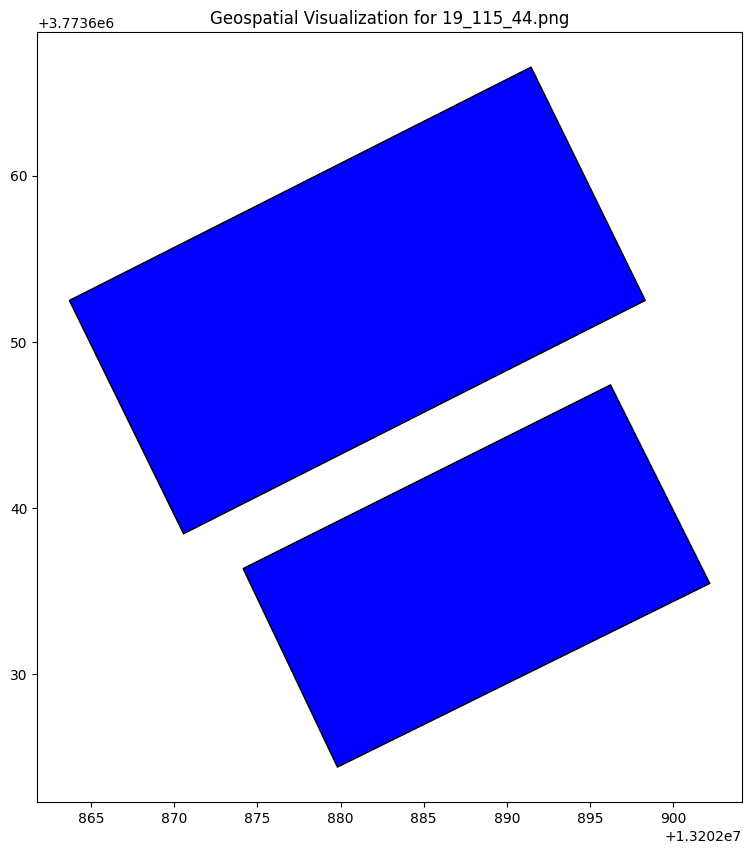

test_images\19_115_45.png
Performing prediction on 9 slices.


01/02/2025 23:10:21 - INFO - pyogrio._io -   Created 10 records


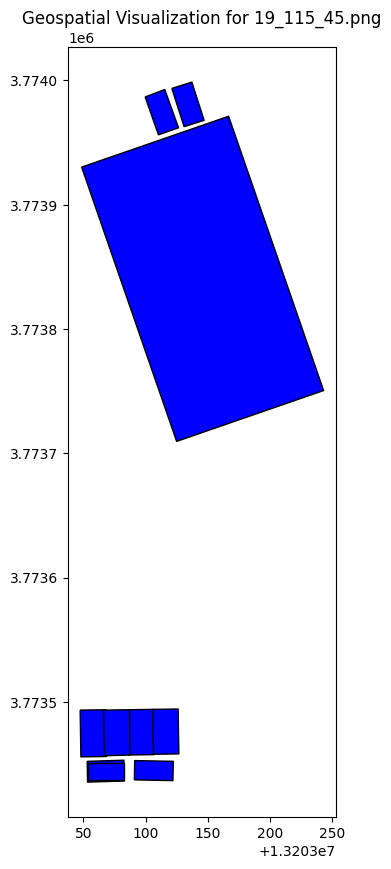

test_images\19_115_57.png
Performing prediction on 9 slices.


01/02/2025 23:10:21 - INFO - pyogrio._io -   Created 0 records


test_images\19_115_95.png
Performing prediction on 9 slices.


01/02/2025 23:10:22 - INFO - pyogrio._io -   Created 2 records


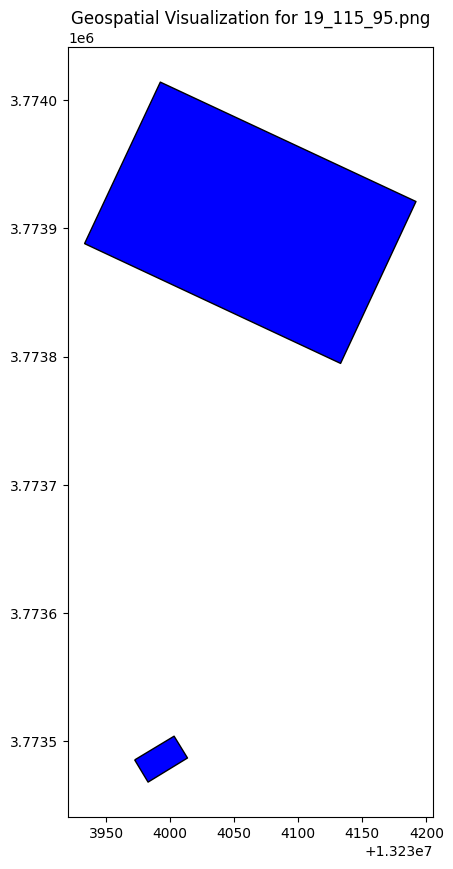

test_images\19_116_54.png
Performing prediction on 9 slices.


01/02/2025 23:10:22 - INFO - pyogrio._io -   Created 0 records


In [69]:
import os
import shapely.geometry
import geopandas as gpd
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from PIL import Image
import numpy as np
import cv2

# 使用 SAHI 加载ultralytics.yolov11-obb模型,并加载本地权重
detection_model = AutoDetectionModel.from_pretrained(
    model_type='ultralytics',
    model_path="runs/obb/v11s-200/weights/best.pt",
    confidence_threshold=0.8,
    device="cuda:0"
)

png_folder = 'test_images'
for png_file in os.listdir(png_folder):
    if png_file.endswith('.png'):
        image_path = os.path.join(png_folder, png_file)
        pngw_path = os.path.splitext(image_path)[0] + '.pngw'

        # Ensure the .pngw file exists before attempting to read it
        if os.path.exists(pngw_path):
            # 读取并解析.pngw文件
            with open(pngw_path, 'r') as f:
                world_data = f.readlines()
                A = float(world_data[0].strip())
                D = float(world_data[1].strip())
                B = float(world_data[2].strip())
                E = float(world_data[3].strip())
                C = float(world_data[4].strip())
                F = float(world_data[5].strip())
        else:
            raise FileNotFoundError(f"{pngw_path} does not exist")

        # 定义像素坐标到地理坐标的仿射变换
        def pixel_to_geo(x, y):
            """
            将像素坐标转换为地理坐标。

            参数:
            x (float): 像素坐标x
            y (float): 像素坐标y
            A (float): 图片上一个像素的宽在x轴方向上的大小
            B (float): 图片上一个像素的高在x轴方向上的大小
            C (float): 图片左上角像素中心点的x坐标
            D (float): 图片上一个像素的宽在y轴方向上的大小
            E (float): 图片上一个像素的高在y轴方向上的大小
            F (float): 图片左上角像素中心点的y坐标

            返回:
            tuple: 地理坐标(geo_x, geo_y)
            """
            # 根据World file的描述，E通常是负值，因此我们使用-E
            geo_x = A * x - B * y + C
            geo_y = D * x + E * y + F
            return geo_x, geo_y
        
        print(image_path)
        # Open the image and convert it to RGB if it has an alpha channel
        image = Image.open(image_path).convert("RGB")

        # 使用 SAHI 对输入的 2048 大小图片进行 1024 分块推理
        result = get_sliced_prediction(
            image,
            detection_model,
            slice_height=1024,
            slice_width=1024,
            overlap_width_ratio=0.2,
            overlap_height_ratio=0.2
        )
        # 可视化预测结果
        if image_path == "test_images/19_115_45.png":
            result.export_visuals(export_dir='output_visuals')

        # 将所有检测框变换到原图坐标系并输出 Shapefile
        geometries = []
        labels = []
        for det in result.object_prediction_list:
            if det.mask is not None:
                # 将布尔掩码转换为8位单通道图像
                bool_mask_8bit = (det.mask.bool_mask * 255).astype(np.uint8)
                # 找到布尔掩码的轮廓
                contours, _ = cv2.findContours(bool_mask_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if not contours:
                    continue
                # 选择最大的轮廓并计算最小外接矩形
                max_contour = max(contours, key=cv2.contourArea)
                rect = cv2.minAreaRect(max_contour)
                box = cv2.boxPoints(rect)
                box = np.int32(box)
                #print(box)
                # 绘制旋转框
                temp_img = np.zeros((image.height, image.width, 3), dtype=np.uint8)
                cv2.drawContours(temp_img, [box.reshape((-1, 1, 2))], 0, (0, 255, 0), 2)
                cv2.imwrite(f'{png_file}_rotated_box.jpg', temp_img)

                # 将像素坐标转换为地理坐标并构造面对象
                geo_coords = [pixel_to_geo(pt[0], pt[1]) for pt in box]
                #print(geo_coords)
                poly = shapely.geometry.Polygon(geo_coords)
                geometries.append(poly)
                # 根据box中的四个点坐标绘制4边形
                polygon_points = np.array([box], dtype=np.int32)
                cv2.polylines(temp_img, [polygon_points], isClosed=True, color=(0, 255, 0), thickness=2)
                labels.append(det.category.name)

        gdf = gpd.GeoDataFrame({'label': labels, 'geometry': geometries})
        gdf.set_crs("EPSG:3857", inplace=True)  # WebMercator投影
        shapefile_path = os.path.join('output_shapefiles', png_file.replace('.png', '.shp'))
        os.makedirs(os.path.dirname(shapefile_path), exist_ok=True)
        gdf.to_file(shapefile_path)
        # 可视化 GeoDataFrame 中的面对象
        import matplotlib.pyplot as plt
        %matplotlib inline
        if not gdf.empty:
            fig, ax = plt.subplots(figsize=(10, 10))
            gdf.plot(ax=ax, color='blue', edgecolor='black')
            plt.title(f"Geospatial Visualization for {png_file}")
            plt.show()
